In [1]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from math import log10,sqrt

In [2]:
train_data=sorted(os.listdir('/kaggle/input/chest-xrays-radiopaedia/images/images'))
noise_data=sorted(os.listdir('/kaggle/input/chest-noisy/chest noisy-20230306T183108Z-001/chest noisy'))

In [3]:
train_data_dir='/kaggle/input/chest-xrays-radiopaedia/images/images'
noise_data_dir='/kaggle/input/chest-noisy/chest noisy-20230306T183108Z-001/chest noisy'

In [4]:
from tqdm.notebook import tqdm
train_image = []
for file in tqdm(sorted(os.listdir(train_data_dir))):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(train_data_dir + '/' + file, target_size=(256,256),color_mode='grayscale')
    image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
    train_image.append(image)

train_image = np.array(train_image)

  0%|          | 0/3662 [00:00<?, ?it/s]

In [5]:
def plot_img(dataset):
  f,ax=plt.subplots(1,5)
  f.set_size_inches(40,20)
  for i in range(5,10):
    ax[i-5].imshow(dataset[i], cmap='gray')
  plt.show()

In [6]:
noised_image = []
for file in tqdm(sorted(os.listdir(noise_data_dir))):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(noise_data_dir + '/' + file, target_size=(256,256),color_mode='grayscale')
    image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
    noised_image.append(image)

noised_image = np.array(noised_image)

  0%|          | 0/3662 [00:00<?, ?it/s]

In [7]:
print(train_image.shape)

(3549, 256, 256, 1)


In [8]:
xnoised=noised_image[:400]
xtest=noised_image[400:]

In [9]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, Reshape, Flatten, Dense, LayerNormalization, MultiHeadAttention, BatchNormalization
from tensorflow.keras.models import Model


In [10]:
def transformer_layer(inputs, n_heads, feed_forward_units, dropout_rate):
    attention_output = MultiHeadAttention(num_heads=n_heads)(inputs, inputs)
    add_attention = LayerNormalization()(inputs + attention_output)
    feed_forward = Dense(units=feed_forward_units, activation="relu")(add_attention)
    feed_forward_output = Dense(inputs.shape[-1])(feed_forward)
    dropout = Dropout(rate=dropout_rate)(feed_forward_output)
    output = LayerNormalization()(add_attention + dropout)
    return output


In [11]:
def autoencoder(n_heads=4, feed_forward_units=512, dropout_rate=0.2):
    # Input layer
    inputs = Input(shape=(256, 256, 1))

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = UpSampling2D((2, 2))(conv5)
    up6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    up6 = BatchNormalization()(up6)
    up6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    up6 = BatchNormalization()(up6)
    merge6 = concatenate([conv4, up6], axis=3)

    up7 = UpSampling2D((2, 2))(merge6)
    up7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    up7 = BatchNormalization()(up7)
    up7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    up7 = BatchNormalization()(up7)
    merge7 = concatenate([conv3, up7], axis=3)

    up8 = UpSampling2D((2, 2))(merge7)
    up8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    up8 = BatchNormalization()(up8)
    up8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    up8 = BatchNormalization()(up8)
    merge8 = concatenate([conv2, up8], axis=3)

    up9 = UpSampling2D((2, 2))(merge8)
    up9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    up9 = BatchNormalization()(up9)
    up9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    up9 = BatchNormalization()(up9)
    merge9 = concatenate([conv1, up9], axis=3)

# Output layer
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(merge9)

# Create model
    model = Model(inputs=[inputs], outputs=[conv10])

    return model

In [12]:
model= autoencoder()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

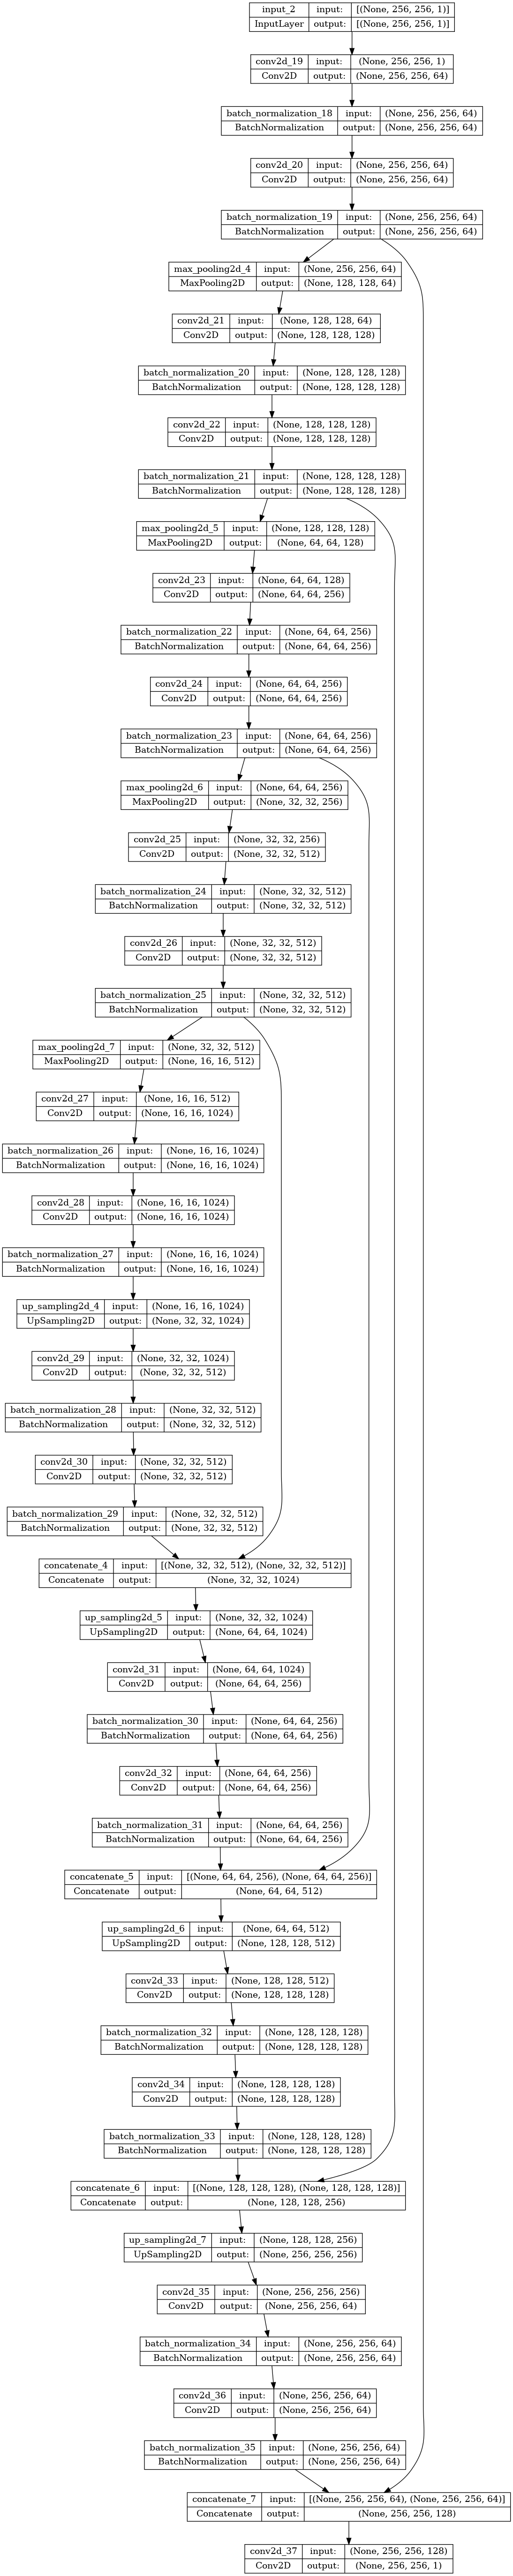

In [13]:
from tensorflow.keras.utils import plot_model
model = autoencoder()
model.compile(optimizer='adam', loss='mse')
plot_model(model, show_shapes=True)

In [14]:
with tf.device('/device:GPU:0'):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
    model.fit(xnoised, xnoised, epochs=2, batch_size=10, validation_data=(xtest, xtest), callbacks=[early_stopping])

Epoch 1/2
40/40 [==============================] - 3885s 99s/step - loss: 0.0117 - val_loss: 0.3311
Epoch 2/2
40/40 [==============================] - 3882s 98s/step - loss: 0.0024 - val_loss: 0.3135


In [15]:
xtrain= train_image[100:]

1/1 [==============================] - 9s 9s/step


IndexError: index 5 is out of bounds for axis 0 with size 5

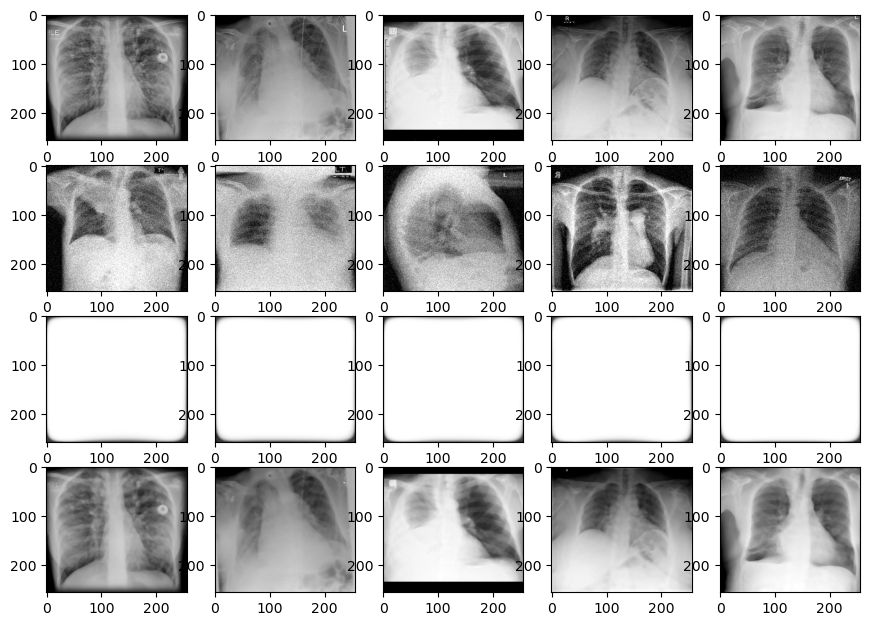

In [16]:
pred= model.predict(xtest[:10])
def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(4, 5)
    f.set_size_inches(10.5,7.5)
    for i in range(10):
        ax[0][i].imshow(np.reshape(xtrain[i], (256,256,1)), aspect='auto', cmap='gray')
        ax[1][i].imshow(np.reshape(y_true[i], (256,256,1)), aspect='auto', cmap='gray')
        ax[2][i].imshow(np.reshape(y_pred[i], (256,256,1)), aspect='auto', cmap='gray')
        ax[3][i].imshow(cv2.medianBlur(xtrain[i], (5)), aspect='auto', cmap='gray')
    plt.tight_layout()
plot_predictions(xtest[:10], pred[:10])

In [17]:
def PSNR(original, denoised): 
    mse = np.mean((original - denoised) ** 2) 
    if(mse == 0): 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

  
#value1 = PSNR(xtrain[0], median_blur)
value2 = PSNR(xtest[0], pred[0])
#value3 = PSNR(xtrain[0], gaussian_blur)
#value4 = PSNR(xtrain[0], average_blur)
#value5 = PSNR(xtrain[0], bilateral_filter)
#value6 = PSNR(xtrain[0],xtest[0])

print("PSNR values")
print(f"Autoencoder Image : {value2} dB")
# print(f"Median Filter Image : {value1} dB")
# print(f"Gaussian Filter Image : {value3} dB")
# print(f"Average Filter Image : {value4} dB")
# print(f"Bilateral Filter Image : {value5} dB")
# print(f"Noisy Image : {value6} dB")

PSNR values
Autoencoder Image : 54.59550338802344 dB
